This notebooks presentes example usage Python SHAP library as
part of Machine Model Interpretability usage.
We use Airbnb Berlin data and trying to interpret prediction we had.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.1 MB/s eta 0:00:00


In [ ]:
%pip install plotly==4.14.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 45.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
import pandas as pd # for data manipulation
import numpy as np  # fast n-dimensional arrays library
import statsmodels.formula.api as smf # for linear regresion
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
from sklearn import preprocessing # for preprocessing for LASSO algorithm
from sklearn.metrics import mean_squared_error # metric for comparing models
from sklearn import linear_model # for LASSO algorithm
import xgboost # for XGBoost algorithm
import shap # for visualization output from XGBoost
from PIL import Image # for images manipulation

In [ ]:
# Use python engine for reading CSV
# See: https://www.shanelynn.ie/pandas-csv-error-error-tokenizing-data-c-error-eof-inside-string-starting-at-line/
data = pd.read_csv('/content/listings_berlin_11_2019.csv', encoding='utf-8', engine='python') # orginal berlin

In [ ]:
# Preprocessing - cast price as float
data.price = data.price.apply(lambda x: x.replace("$", ""))
data.price = data.price.apply(lambda x: x.replace(",", ""))
data.price = data.price.astype("float")

In [ ]:
# Enrich data by calculate zip code relation to price
# amenities_len -> value for comparing number of amenities across offerts
# zip_count -> number of offerts in close location
# zip_price -> average price for offerts in the same location

temp_zipcode = data.zipcode.copy()
data['zipcode2'] = temp_zipcode.str.replace("\D+", "", ).copy()
data.zipcode2.fillna(0, inplace=True)
x_count = data.groupby('zipcode2')['id'].nunique()
x_mean = data.groupby('zipcode2')['price'].mean()

x_count_dict = x_count.to_dict()
x_mean_dict = x_mean.to_dict()

a1 = np.zeros((len(data), 6))
print(a1)
for i in range(0,len(data)):
    val = data.zipcode2[i]
    a1[i][0] = data.id[i]
    a1[i][1] = x_count_dict[val]
    a1[i][2] = x_mean_dict[val]
    #a1[i][3] = val
    a1[i][4] = len(data.amenities[i])

#data['amenities_len'] = a1[:,3]
data['zipcode_count'] = a1[:,1]
data['zipcode_price'] = a1[:,2]
print(data.head())

<ipython-input-11-84000f0ee826>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.zipcode2.fillna(0, inplace=True)


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
     id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   
1                Prenzlauer Berg close to Mauerpark   
2                   Fabulous Flat in great Location   
3                 BerlinSpot Schöneberg near KaDeWe   
4                  BrightRoom with sunny greenview!   

                                             summary  \
0  Great location!  30 of 75 s

In [ ]:
# Preprocessing - get rid of outliers
print("99.7% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.7)))
data = data[(data.price <= np.percentile(data.price, 99.7)) & (data.price > 0)]

99.7% properties have a price lower than  550.00


In [ ]:
cols = ['price', 'host_is_superhost', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'beds', 'bathrooms']
cols2 = ['minimum_nights', 'zipcode_count', 'zipcode_price']
cols = cols + cols2
cols

['price',
 'host_is_superhost',
 'bedrooms',
 'number_of_reviews',
 'review_scores_rating',
 'beds',
 'bathrooms',
 'minimum_nights',
 'zipcode_count',
 'zipcode_price']

In [ ]:
# Preprocessing - replace NaN values with mean from column
# With checking before and after replacement

print(data[cols].isna().sum())
#data.fillna((data[cols].mean()), inplace=True)
print(data[cols].isna().sum())


price                      0
host_is_superhost         25
bedrooms                  18
number_of_reviews          0
review_scores_rating    4349
beds                      39
bathrooms                 32
minimum_nights             0
zipcode_count              0
zipcode_price              0
dtype: int64
price                      0
host_is_superhost         25
bedrooms                  18
number_of_reviews          0
review_scores_rating    4349
beds                      39
bathrooms                 32
minimum_nights             0
zipcode_count              0
zipcode_price              0
dtype: int64


In [ ]:
# Convert remaining columns to float type
data['number_of_reviews'] = data['number_of_reviews'].astype(float)
data['accommodates'] = data['accommodates'].astype(float)
#data['amenities_len'] = data['amenities_len'].astype(float)
data['minimum_nights'] = data['minimum_nights'].astype(float)

In [ ]:
data_subset = data

data = pd.DataFrame(data_subset)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(data_subset['price'], name="Price")

from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(
    data, target, test_size=0.2
)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(17983, 99)
(4496, 99)
(17983,)
(4496,)


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cmap
import math
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import shap
from collections import namedtuple

In [ ]:
class DataHandling:

    def __init__(self, file_name, columns):
        self.file_name = file_name
        self.columns = columns
        self.day_map = {'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6}

    def acquire_data(self, url):
        response = requests.get(url, stream=True)
        with open(self.file_name, "wb") as data:
            data.write(response.content)
        response.close()

    def _load_data(self):
        return pd.read_csv(self.file_name)

    @staticmethod
    def calculate_heat_index(t, h):
        f = ((t * 9/5) + 32)
        t2 = math.pow(f, 2)
        h2 = math.pow(h, 2)

        c = [ 0.363445176, 0.988622465, 4.777114035, -0.114037667, -0.000850208, -0.020716198, 0.000687678, 0.000274954, 0]

        heat_index =  c[0] + (c[1]*f) + (c[2]*h) + (c[3]*f*h) + (c[4]*t2) + (c[5]*h2) + (c[6]*t2*h) + (c[7]*f*h2) + (c[8]*t2*h2)

        return ((heat_index - 32) * 5/9)

    def get_fire_data(self):
        df = self._load_data()
        df.columns = self.columns
        df['month'] = pd.to_datetime(df.month, format='%b').dt.month
        df['day'] = df['day'].apply(lambda x: self.day_map[x])
        df['heat_index'] = df.apply(lambda x: self.calculate_heat_index(x['temperature'], x['relative_humidity']), axis=1)
        return df


In [ ]:
class DataValidation:

    def __init__(self, data):
        self.data = data

    def plot_correlation(self):
        corr = self.data.corr()
        with plt.style.context('seaborn-v0_8'):
            fig, ax = plt.subplots(figsize=(14, 12))
            sns.heatmap(corr, ax=ax, cmap=cmap.copper_r)

    def plot_pairwise(self):
        pd.plotting.scatter_matrix(self.data, figsize=(24,24))

    def plot_hist(self, feature, bins):
        with plt.style.context('seaborn-v0_8'):
            fig, ax = plt.subplots(figsize=(14, 10))
            plt.hist(self.data[feature], bins=bins)

    def plot_area_map(self, x, y, column):
        grouped = self.data.groupby([x, y])[column].mean().reset_index()
        pivoted = grouped.pivot(index=y, columns=x, values=column)
        with plt.style.context('seaborn-v0_8'):
            fig, ax = plt.subplots(figsize=(14,12))
            sns.heatmap(pivoted, cmap=cmap.copper_r, ax=ax)
            ax.invert_yaxis()

In [ ]:
class ModelScoring:

    def __init__(self, y_test, y_pred, param_count, algorithm):
        self.y_test = y_test
        self.y_pred = y_pred
        self.n = len(y_test)
        self.param_count = param_count
        self.algorithm = algorithm

    def _mse_calc(self):
        return mean_squared_error(self.y_test, self.y_pred)

    def _bic(self):
        return self.n * np.log(self._mse_calc()) + self.param_count * np.log(self.n)

    def _rmse(self):
        return np.sqrt(self._mse_calc())

    def evaluate(self):
        return {'rmse': self._rmse(), 'bic': self._bic()}[self.algorithm]

In [ ]:
class DataPrep:

    def __init__(self, data, label, test_size=0.3):
        self.data = data
        self.label = label
        self.test_size = test_size

    def split_features(self):
        Data = namedtuple('Data', 'X y')
        X = self.data.drop([self.label], axis=1)
        y = self.data[self.label]
        return Data(X, y)

    def train_test_split(self, stratify_column):
        TrainTest = namedtuple('Data', 'X_train X_test y_train y_test X y')
        split_data = self.split_features()
        X_train, X_test, y_train, y_test = train_test_split(split_data.X,
                                                            split_data.y,
                                                            #stratify=split_data.X[stratify_column],
                                                            test_size=self.test_size
                                                           )
        return TrainTest(X_train, X_test, y_train, y_test, split_data.X, split_data.y)


In [ ]:
class ImageHandling:

    def __init__(self, fig, name):
        self.fig = fig
        self.name = name

    def _resize_plot(self):
        self.fig = plt.gcf()
        self.fig.set_size_inches(12, 12)

    def save_base(self):
        self.fig.savefig(f"{self.name}.png", format='png', bbox_inches='tight')
        self.fig.savefig(f"{self.name}.svg", format='svg', bbox_inches='tight')

    def save_plt(self):
        self._resize_plot()
        self.save_base()

    def save_js(self):
        shap.save_html(self.name, self.fig)
        return self.fig

class ShapConstructor:

    def __init__(self, base_values, data, values, feature_names, shape):
        self.base_values = base_values
        self.data = data
        self.values = values
        self.feature_names = feature_names
        self.shape = shape

class ShapObject:

    def __init__(self, model, data):
        self.model = model
        self.data = data
        self.exp = self.generate_explainer(self.model, self.data)
        shap.initjs()

    @classmethod
    def generate_explainer(self, model, data):
        Explain = namedtuple('Explain', 'shap_values explainer max_row')
        explainer = shap.Explainer(model)
        explainer.expected_value = explainer.expected_value[0]
        shap_values = explainer(data)
        max_row = len(shap_values.values)
        return Explain(shap_values, explainer, max_row)

    def build(self, row=0):
        return ShapConstructor(base_values = self.exp.shap_values[0][0].base_values,
                               values = self.exp.shap_values[row].values,
                               feature_names = self.data.columns,
                               data = self.exp.shap_values[0].data,
                               shape = self.exp.shap_values[0].shape)

    def validate_row(self, row):
        assert row < self.exp.max_row, f"The row value: {row} is invalid. Data has only {self.exp.max_row} rows."

    def plot_waterfall(self, row=0):
        plt.clf()
        self.validate_row(row)
        #fig = shap.waterfall_plot(self.build(row), show=False, max_display=15)
        self.exp = self.generate_explainer(self.model,row)
        fig = shap.waterfall_plot(self.exp)
        ImageHandling(fig, f"summary_{row}").save_plt()
        return fig

    def plot_summary(self):
        fig = shap.plots.beeswarm(self.exp.shap_values, show=False, max_display=15)
        ImageHandling(fig, "summary").save_plt()

    def plot_force_by_row(self, row=0):
        plt.clf()
        self.validate_row(row)
        fig = shap.force_plot(self.exp.explainer.expected_value,
                               self.exp.shap_values.values[row,:],
                               self.data.iloc[row,:],
                               show=False,
                               matplotlib=True
                              )
        ImageHandling(fig, f"force_plot_{row}").save_base()

    def plot_full_force(self):
        fig = shap.plots.force(self.exp.explainer.expected_value,
                               self.exp.shap_values.values,
                               show=False
                              )
        final_fig = ImageHandling(fig, "full_force_plot.htm").save_js()
        return final_fig

    def plot_shap_importances(self):
        fig = shap.plots.bar(self.exp.shap_values, show=False, max_display=15)
        ImageHandling(fig, "shap_importances").save_plt()

    def plot_scatter(self, feature):
        fig = shap.plots.scatter(self.exp.shap_values[:, feature], color=self.exp.shap_values, show=False)
        ImageHandling(fig, f"scatter_{feature}").save_plt()


In [ ]:
class RandomForestTuning:

    def __init__(self, data, label, stratify_column, trials, test_size=0.3, metric='rmse'):
        self.data = data
        self.label = label
        self.stratify_column = stratify_column
        self.trials = trials
        self.test_size = test_size
        self.metric = metric

    @staticmethod
    def _random_forest_model(**kwargs):
        model = RandomForestRegressor(n_estimators=kwargs['n_estimators'],
                                      max_depth=kwargs['max_depth'],
                                      min_samples_split=kwargs['min_samples_split'],
                                      min_samples_leaf=kwargs['min_samples_leaf'],
                                      max_leaf_nodes=kwargs['max_leaf_nodes'],
                                      min_impurity_decrease=kwargs['min_impurity_decrease'],
                                      max_features=kwargs['max_features'],
                                      n_jobs=-1
                                     )
        return model

    def _run_trial(self, trial):
        splits = DataPrep(self.data, self.label, self.test_size).train_test_split(self.stratify_column)
        params = {
                 'n_estimators': trial.suggest_int("n_estimators", 50, 2000, 10),
                 'max_depth': trial.suggest_int("max_depth", 2, 24, 1),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 25, 1),
                 'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20, 1),
                 'max_leaf_nodes': trial.suggest_int("max_leaf_nodes", 4, 400, 1),
                 'min_impurity_decrease': trial.suggest_loguniform("min_impurity_decrease", 1e-22, 1e-3),
                 'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2'])
                }

        model = self._random_forest_model(**params).fit(splits.X_train, splits.y_train)

        return ModelScoring(splits.y_test, model.predict(splits.X_test), len(params.keys()), self.metric).evaluate()

    def run(self):
        trial = optuna.create_study(direction='minimize')
        trial.optimize(self._run_trial, self.trials)
        return trial

class RandomForestBuilder:

    def __init__(self, trial, cls):
        self.trial = trial
        self.cls = cls

    def _extract_best_gen_model(self):
        Extract = namedtuple('Extract', 'model X y')
        full_data = DataPrep(self.cls.data,
                             self.cls.label,
                             self.cls.test_size).split_features()
        best_params = self.trial.best_params

        model = self.cls._random_forest_model(**best_params)
        return Extract(model, full_data.X, full_data.y)

    def extract_best_and_build(self):
        ModelData = namedtuple('ModelData', 'model X y')
        model = self._extract_best_gen_model()
        final_model = model.model.fit(model.X, model.y)
        return ModelData(final_model, model.X, model.y)

In [ ]:
variables = ['bedrooms','beds','bathrooms','zipcode_count','zipcode_price','number_of_reviews','review_scores_rating', 'guests_included', 'minimum_nights']
data.fillna((data[variables + ['price']].mean()), inplace=True)

data_subset = data.loc[:, variables + ['price']]
random_forest_tune = RandomForestTuning(data_subset, 'price', 'minimum_nights', 200, 0.15, 'rmse')
trial_rf = random_forest_tune.run()
final_rf_model = RandomForestBuilder(trial_rf, random_forest_tune).extract_best_and_build()

[I 2025-04-08 07:46:37,192] A new study created in memory with name: no-name-0c0ede37-d6ea-462e-b13e-25c9f9efed73
<ipython-input-23-037048dbabe2>:27: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int("n_estimators", 50, 2000, 10),
<ipython-input-23-037048dbabe2>:28: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int("max_depth", 2, 24, 1),
<ipython-input-23-037048dbabe2>:29: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'min_samples_split': trial.suggest_int("min_samples_split", 2, 25, 1),
<ipython-input-23-037048dbabe2>:30: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'min_samples_leaf': trial.suggest_int("min_samples_

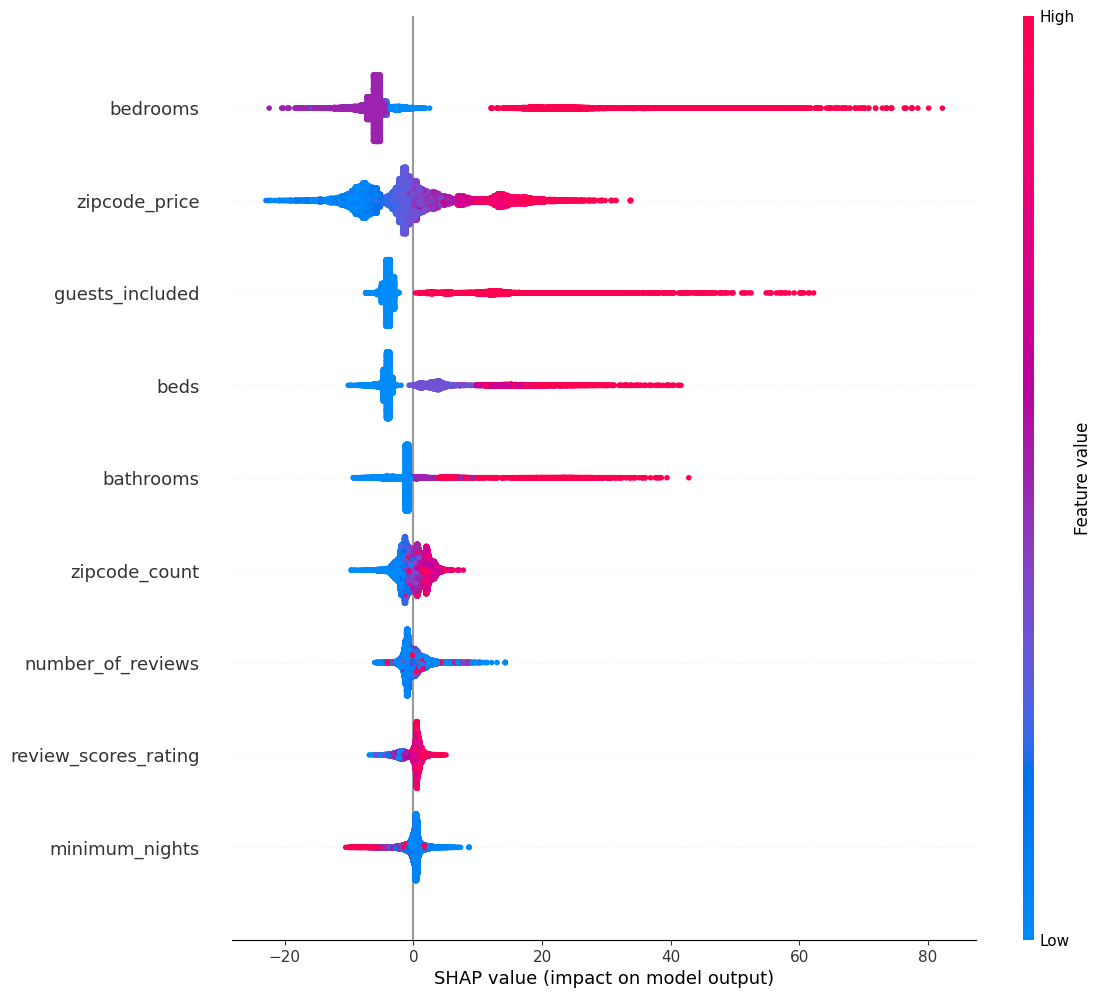

In [ ]:
shap_obj = ShapObject(final_rf_model.model, final_rf_model.X)
shap_obj.plot_summary()

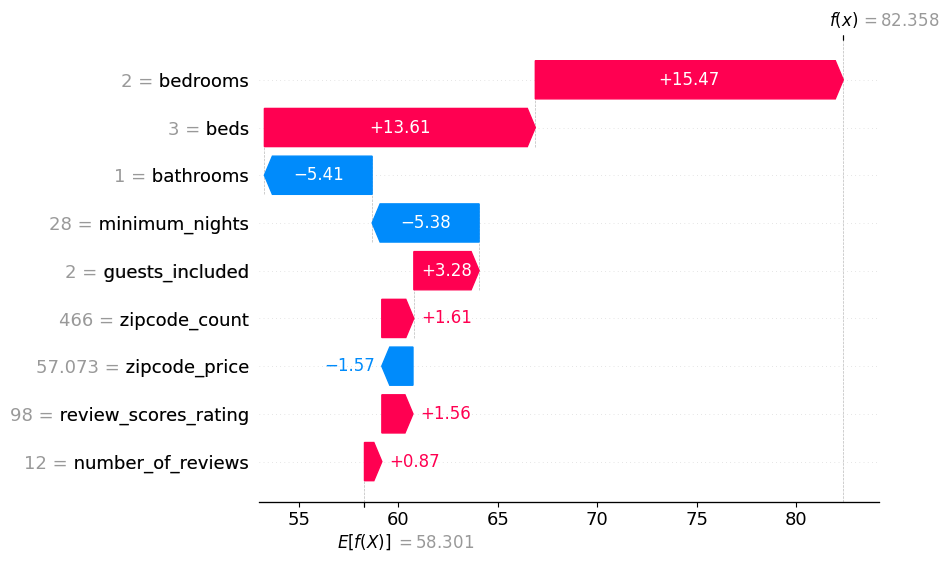

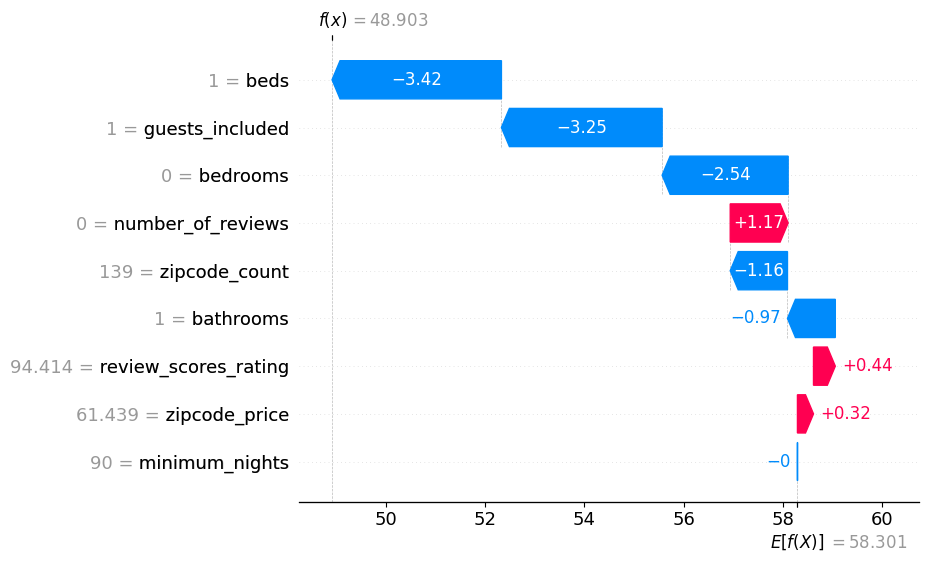

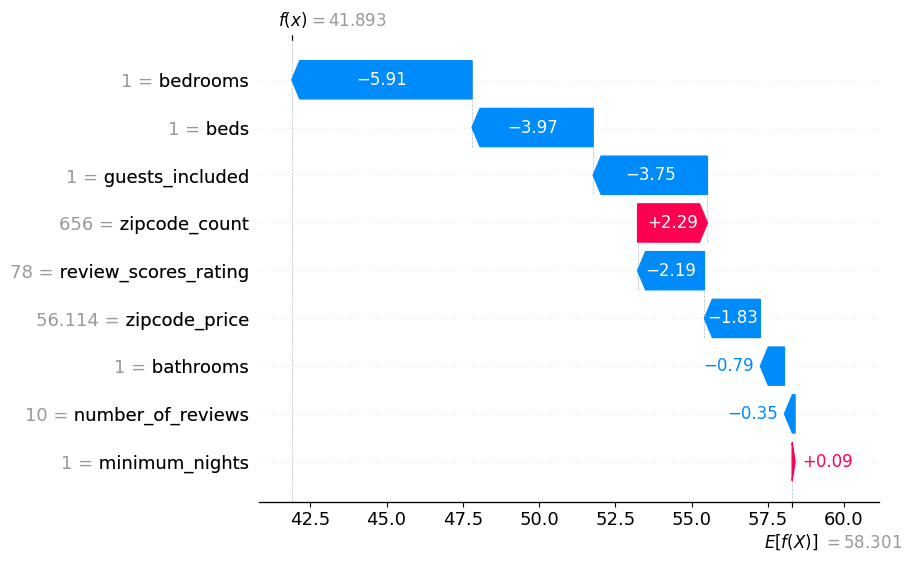

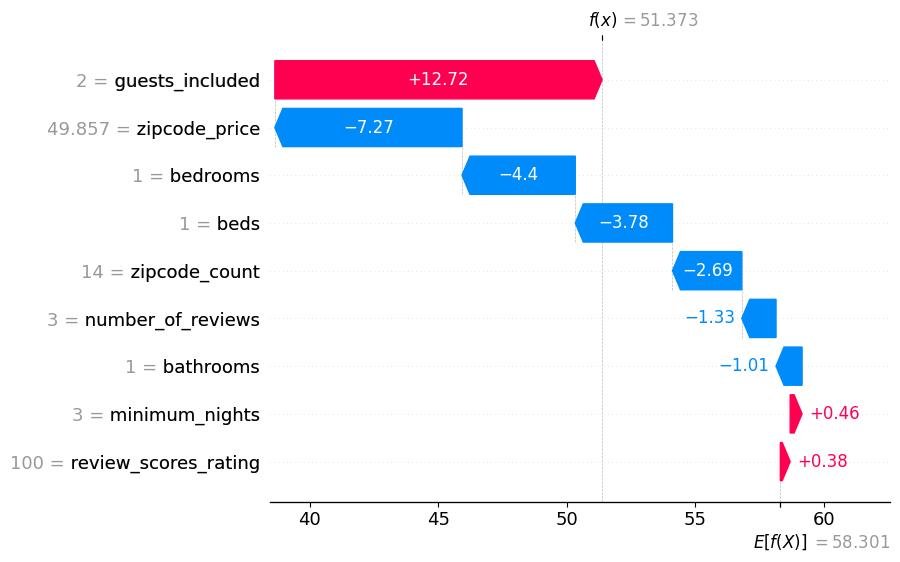

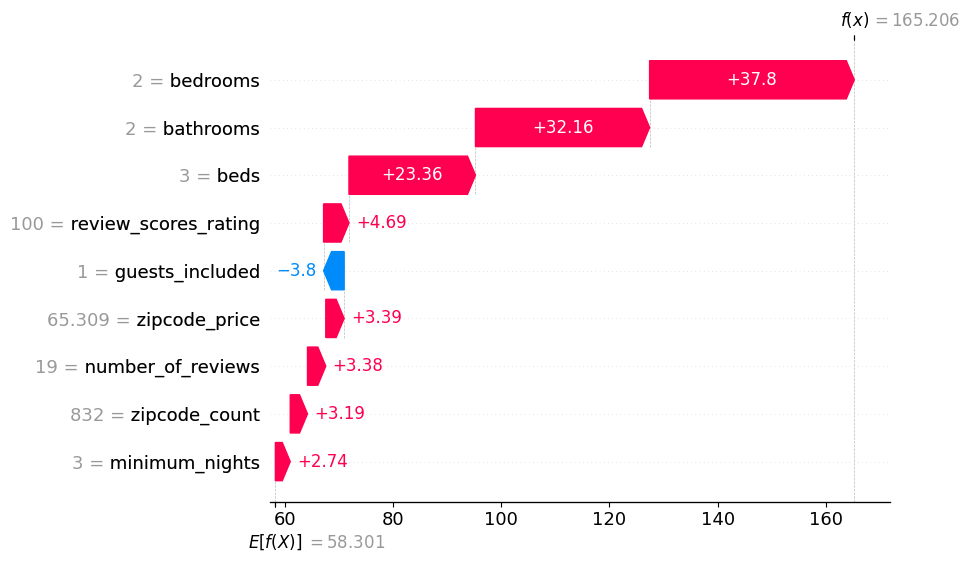

In [ ]:
interesting_rows = data_subset.nlargest(5, 'price').reset_index()['index'].values
#print(interesting_rows)
waterfalls = [shap.plots.waterfall(shap_obj.exp[0][x]) for x in interesting_rows]
